In [129]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 777.1 MB 12 kB/s  eta 0:00:015   |▌                               | 12.3 MB 6.9 MB/s eta 0:01:51     |▋                               | 14.1 MB 6.9 MB/s eta 0:01:51     |▊                               | 18.3 MB 8.0 MB/s eta 0:01:35     |█                               | 24.6 MB 5.9 MB/s eta 0:02:08     |█                               | 26.5 MB 5.9 MB/s eta 0:02:08     |█▍                              | 34.8 MB 9.0 MB/s eta 0:01:23     |█▌                              | 37.2 MB 9.0 MB/s eta 0:01:22     |█▋                              | 38.6 MB 9.6 MB/s eta 0:01:17     |██▉                             | 68.8 MB 6.7 MB/s eta 0:01:47     |███                             | 71.3 MB 6.7 MB/s eta 0:01:46     |███▎                            | 79.4 MB 6.3 MB/s eta 0:01:52     |███▉                            | 92.3 MB 10.5 MB/s eta 0:01:06     |████                            | 96.8 MB 10.5 MB/s eta 0:01:05     |████▏                           | 100.0 

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [130]:
import numpy as np
import pandas as pd
import selenium as se
import seaborn as sns
import spacy
import openpyxl
import nltk
import ssl
import re
import sklearn
import gensim

from bs4 import BeautifulSoup as bs
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

# NLP stuff
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from spacy.pipeline import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

In [147]:
df_big_easy = pd.read_excel('Reviews.xlsx')
df_big_easy.head()

,author,reviewBody,reviewRating,ratingMaxvalue,reviewTags,dateCreated,images,reviewUrl,reviewSource,orginalText,name,reviewCount,aggregateRating,address,place_id,input,businessUrl
0,Aaron Gregory,"Our server Marco, was on point with covid guid...",3.0,5.0,NaN,2 months ago,NaN,https://www.google.com/maps/contrib/1087222116...,www.google.com,NaN,Big Easy Canary Wharf,"3,516",3.9,"Crossrail Pl, London, United Kingdom",ChIJj5YwFrcCdkgRZ7QcD-FJ2Zo,https://www.google.com/maps/place/Big+Easy+Can...,https://www.google.com/maps/place/?q=place_id:...
1,Clement Escaffre,Counter reservations apparently don't give you...,1.0,5.0,NaN,a year ago,NaN,https://www.google.com/maps/contrib/1087579170...,www.google.com,NaN,Big Easy Canary Wharf,"3,516",3.9,"Crossrail Pl, London, United Kingdom",ChIJj5YwFrcCdkgRZ7QcD-FJ2Zo,https://www.google.com/maps/place/Big+Easy+Can...,https://www.google.com/maps/place/?q=place_id:...
2,Amanjot Klair,Good food. But there is a foul smell that find...,4.0,5.0,NaN,a year ago,NaN,https://www.google.com/maps/contrib/1014737661...,www.google.com,NaN,Big Easy Canary Wharf,"3,516",3.9,"Crossrail Pl, London, United Kingdom",ChIJj5YwFrcCdkgRZ7QcD-FJ2Zo,https://www.google.com/maps/place/Big+Easy+Can...,https://www.google.com/maps/place/?q=place_id:...
3,Deividas Petrauskas,NaN,4.0,5.0,NaN,a year ago,NaN,https://www.google.com/maps/contrib/1157723729...,www.google.com,NaN,Big Easy Canary Wharf,"3,516",3.9,"Crossrail Pl, London, United Kingdom",ChIJj5YwFrcCdkgRZ7QcD-FJ2Zo,https://www.google.com/maps/place/Big+Easy+Can...,https://www.google.com/maps/place/?q=place_id:...
4,Hiro,British pub with amazing line of draft beers -...,5.0,5.0,NaN,a year ago,NaN,https://www.google.com/maps/contrib/1141368057...,www.google.com,NaN,Big Easy Canary Wharf,"3,516",3.9,"Crossrail Pl, London, United Kingdom",ChIJj5YwFrcCdkgRZ7QcD-FJ2Zo,https://www.google.com/maps/place/Big+Easy+Can...,https://www.google.com/maps/place/?q=place_id:...


In [149]:
df_big_easy.shape

(1000, 17)

### Keep interesting columns, remove rows with review missing

In [150]:
df_big_easy_clean = df_big_easy[['reviewBody', 'reviewRating', 'dateCreated']].copy(deep=True)
df_big_easy_clean = df_big_easy_clean.dropna(subset=['reviewBody'])
print(df_big_easy_clean.shape)
df_big_easy_clean.head()

(621, 3)


,reviewBody,reviewRating,dateCreated
0,"Our server Marco, was on point with covid guid...",3.0,2 months ago
1,Counter reservations apparently don't give you...,1.0,a year ago
2,Good food. But there is a foul smell that find...,4.0,a year ago
4,British pub with amazing line of draft beers -...,5.0,a year ago
6,"Waited for 15m to get served at the bar, wasti...",1.0,a year ago


### Date cleaning

Turn '1 week ago', '6 hours ago' etc. into dates

In [153]:
# Turn strings into dates
def clean_date(string_date):
    curr_date = datetime.now()
    split_date = string_date.split(' ')

    n = split_date[0]
    n = 1 if n in ('a', 'an') else int(n) # Replace 'a week ago' / 'an hour ago' with '1 week ago'
    
    delta = split_date[1]
    
    # Check assumption that any n>1 must be plural
    assert (n==1) or (n>1 and delta[-1]=='s')
    
    # Stip trailing 's' from delta
    if n>1:
        delta = delta[:-1]

    if delta == 'year':
        return curr_date - timedelta(days=365*n)
    elif delta == 'month':
        return curr_date - timedelta(days=30*n)
    elif delta == 'week':
        return curr_date - timedelta(weeks=n)
    elif delta == 'day':
        return curr_date - timedelta(days=n)
    elif delta == 'hour':
        return curr_date - timedelta(hours=n)
    elif delta == 'minute':
        return curr_date - timedelta(minutes=n)
    elif delta == 'moment':
        return curr_date - timedelta(seconds=n)
    else:
        raise ValueError(f'Unhandled delta type {delta}')

In [154]:
df_big_easy_clean['date_clean'] = df_big_easy_clean['dateCreated'].apply(lambda d: clean_date(d)).astype('datetime64[D]')
df_big_easy_clean.head()

,reviewBody,reviewRating,dateCreated,date_clean
0,"Our server Marco, was on point with covid guid...",3.0,2 months ago,2021-05-30
1,Counter reservations apparently don't give you...,1.0,a year ago,2020-07-29
2,Good food. But there is a foul smell that find...,4.0,a year ago,2020-07-29
4,British pub with amazing line of draft beers -...,5.0,a year ago,2020-07-29
6,"Waited for 15m to get served at the bar, wasti...",1.0,a year ago,2020-07-29


### Language cleaning

Only keep English reviews (run the below if you need to download corpus).

In [114]:
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download()

Start by cleaning text

In [155]:
def clean_text(text):
    
    tokens = text.split(' ')
    tokens_lower = [t.lower() for t in tokens]
    tokens_alpha = [re.sub('[^A-z]', '', t) for t in tokens_lower]
    text_clean = ' '.join(tokens_alpha)
    
    return text_clean
    

df_big_easy_clean['review_lower_alpha'] = df_big_easy_clean.apply(lambda row: clean_text(row['reviewBody']),
                                                                  axis=1)

df_big_easy_clean.head()

,reviewBody,reviewRating,dateCreated,date_clean,review_lower_alpha
0,"Our server Marco, was on point with covid guid...",3.0,2 months ago,2021-05-30,our server marco was on point with covid guide...
1,Counter reservations apparently don't give you...,1.0,a year ago,2020-07-29,counter reservations apparently dont give you ...
2,Good food. But there is a foul smell that find...,4.0,a year ago,2020-07-29,good food but there is a foul smell that find ...
4,British pub with amazing line of draft beers -...,5.0,a year ago,2020-07-29,british pub with amazing line of draft beers ...
6,"Waited for 15m to get served at the bar, wasti...",1.0,a year ago,2020-07-29,waited for m to get served at the bar wasting ...


Then check how many words are in English corpus.

In [156]:
eng_words = words.words('en')
eng_words_lower = [w.lower() for w in eng_words]

In [157]:
from nltk.corpus import stopwords
# nltk.download('stopwords')
sw = stopwords.words('english')

In [158]:
df_big_easy_eng = df_big_easy_clean.copy(deep=True)

# Assume any review where > 50% of first 10 words are in English corpus, is an English review
def pct_review_words_in_eng_corpus(text):
    
    tokens = text.split(' ')[:10]
    n_tokens = len(tokens)
    tokens_in_eng_corpus = np.sum([1 if t in eng_words_lower else 0 for t in tokens])
    
    return float(tokens_in_eng_corpus)/n_tokens


df_big_easy_eng['is_english'] = df_big_easy_eng.apply(lambda row: pct_review_words_in_eng_corpus(row['review_lower_alpha']) >= 0.5,
                                                      axis=1)

# Drop rows
df_big_easy_eng = df_big_easy_eng[df_big_easy_eng['is_english']==True].drop(['is_english'], axis=1)

# Then remove stopwords
def remove_stopwords(text):
    
    tokens = text.split(' ')
    tokens_no_sw = [t for t in tokens if t not in sw]
    
    return ' '.join(tokens_no_sw)

df_big_easy_eng['review_clean'] = df_big_easy_eng['review_lower_alpha'].apply(lambda t: remove_stopwords(t))
df_big_easy_eng = df_big_easy_eng.drop('review_lower_alpha', axis=1)

df_big_easy_eng.head()

,reviewBody,reviewRating,dateCreated,date_clean,review_clean
0,"Our server Marco, was on point with covid guid...",3.0,2 months ago,2021-05-30,server marco point covid guide lines service g...
1,Counter reservations apparently don't give you...,1.0,a year ago,2020-07-29,counter reservations apparently dont give tabl...
2,Good food. But there is a foul smell that find...,4.0,a year ago,2020-07-29,good food foul smell find every time times ev...
4,British pub with amazing line of draft beers -...,5.0,a year ago,2020-07-29,british pub amazing line draft beers truffel ...
6,"Waited for 15m to get served at the bar, wasti...",1.0,a year ago,2020-07-29,waited get served bar wasting sizeable chunk l...


### Analysis

<AxesSubplot:xlabel='reviewRating', ylabel='count'>

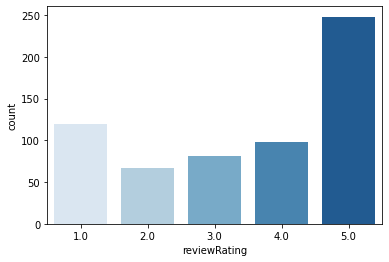

In [159]:
sns.countplot(data=df_big_easy_eng,
              x='reviewRating',
              palette='Blues')

Look over time

In [170]:
pd._version

<module 'pandas._version' from '/Users/jackcook/PycharmProjects/reviews-tool/venv/lib/python3.7/site-packages/pandas/_version.py'>

In [174]:
df_monthly = df_big_easy_eng.set_index('date_clean').resample('M')['reviewRating'].agg(('mean','count'))
df_monthly #= df_monthly.query('')

,mean,count
date_clean,,
2020-07-31,3.581395,301
2020-08-31,NaN,0
2020-09-30,4.000000,2
2020-10-31,4.222222,9
2020-11-30,3.755102,49
2020-12-31,3.348837,43
2021-01-31,5.000000,2
2021-02-28,NaN,0
2021-03-31,3.000000,4


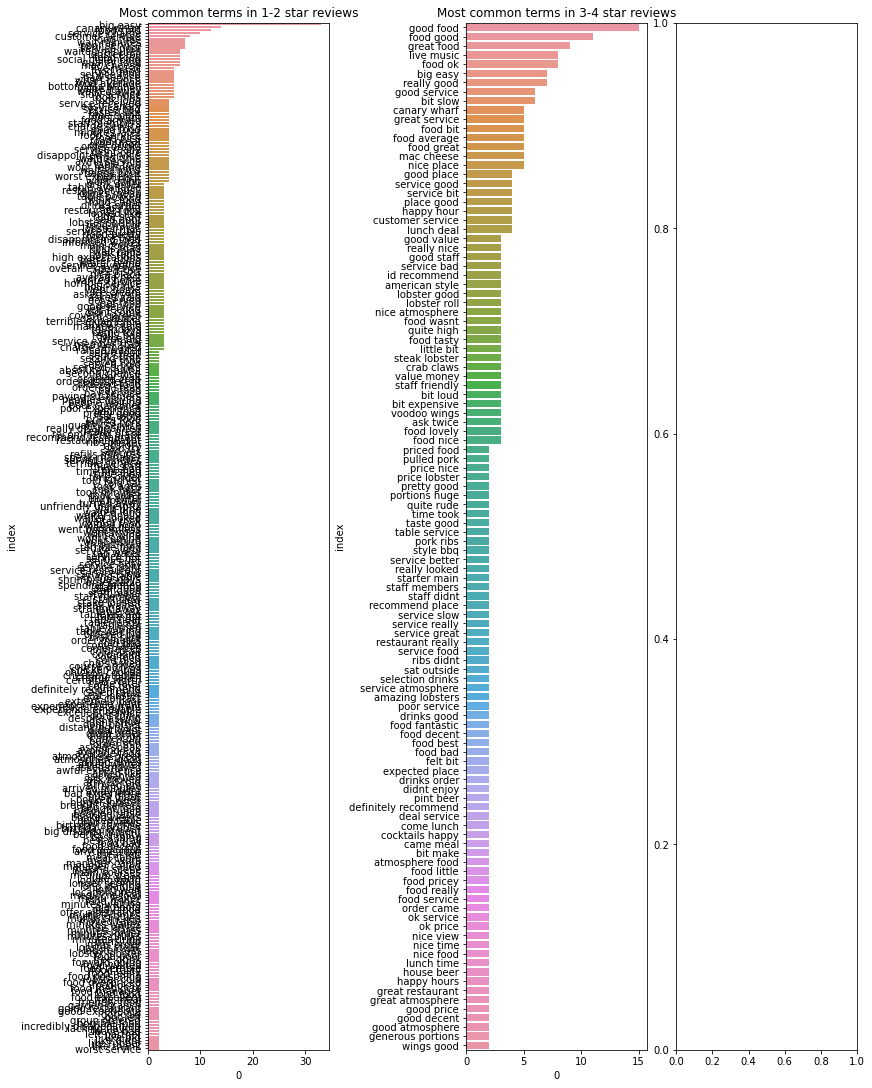

In [178]:
from sklearn.feature_extraction.text import CountVectorizer

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,15),
                        constrained_layout=True)

# Bucket reviews into 1-2 stars, 3-4 stars, and 5 stars
review_buckets = {0: [1, 2], 
                  1: [3, 4], 
                  2: [5, 5]}

for i in range(2):
    
    # Get review bucket
    rev_min, rev_max = review_buckets[i]
    
    # Filter for certain reviews
    df_filt = df_big_easy_eng.query(f'reviewRating>={rev_min} and reviewRating<={rev_max}')
    
    # Set up vectorizer
    C = CountVectorizer(ngram_range=(2,2),
                        max_df=1.0,
                        min_df=2,
                        stop_words='english')
    
    # Get counts
    res = C.fit_transform(df_filt['review_clean'])
    
    # Set up dataframe
    df_res = pd.DataFrame(data=res.todense(),
                          columns=C.get_feature_names())
    

    # Turn into plottable format
    df_plot = df_res.T.apply(lambda row: np.sum(row), axis=1).sort_values(ascending=False).reset_index()
    
    # Plot
    sns.barplot(data=df_plot,
                # When you use reset_index() on a series, you end up with index and 0 as column names
                x=0,
                y='index',
                ax=axs[i])
    
    if rev_min == rev_max:
        title_stars = f'{rev_min} star'
    else:
        title_stars = f'{rev_min}-{rev_max} star'
    
    axs[i].set_title(f'Most common terms in {title_stars} reviews')

In [179]:
df_big_easy_eng['review_clean']

0      server marco point covid guide lines service g...
1      counter reservations apparently dont give tabl...
2      good food foul smell find every time  times ev...
4      british pub amazing line draft beers  truffel ...
6      waited get served bar wasting sizeable chunk l...
                             ...                        
991    ordered  food arrived   plate  sides cocktails...
993    positives place looks lavish inside atmosphere...
994    great place enjoy steak lobsters large glass b...
996                                                 nice
998    dont bother boozy brunch  changed rules order ...
Name: review_clean, Length: 614, dtype: object

In [134]:
nlp = spacy.load("en_core_web_lg")

In [189]:
doc = nlp(df_big_easy_eng.reset_index()['reviewBody'][400])

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

Visited visit VERB VBN advcl Xxxxx True False
with with ADP IN prep xxxx True True
my my PRON PRP$ poss xx True True
associates associate NOUN NNS pobj xxxx True False
after after ADP IN prep xxxx True True
a a DET DT det x True True
long long ADJ JJ amod xxxx True False
day day NOUN NN pobj xxx True False
to to PART TO aux xx True True
enjoy enjoy VERB VB advcl xxxx True False
a a DET DT det x True True
good good ADJ JJ amod xxxx True False
meal meal NOUN NN dobj xxxx True False
and and CCONJ CC cc xxx True True
to to ADP IN prep xx True True
my my PRON PRP$ poss xx True True
surprise surprise NOUN NN pobj xxxx True False
I I PRON PRP nsubjpass X True True
was be AUX VBD auxpass xxx True True
served serve VERB VBN conj xxxx True False
a a DET DT det x True True
£ £ SYM $ nmod £ False False
31cold 31cold NUM CD nummod ddxxxx False False
dry dry ADJ JJ amod xxx True False
fillet fillet NOUN NN dobj xxxx True False
with with ADP IN prep xxxx True True
half half ADJ JJ amod xxxx True Fals

In [190]:
spacy.displacy.render(doc)

In [191]:
spacy.displacy.render(doc, style='ent')